# Data Preprocessing

I will be merging cash flow, income, and balance sheet data into one useable dataframe. 
I'll start with only a few tickers (10) to save memory, and eventually put this is on a virtual machine to mine the entire dataset.

_____________________________
## Outline

- Importing the libraries
- Importing the Dataset
- Handling of Missing Data
- Mine new features (ratios, etc.)
- Handling of Categorical Data
- Splitting the dataset into training and testing datasets
- Feature Scaling
- Uploading data to S3


## Importing the libraries

In [1]:
import simfin as sf
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import timedelta
import datetime
from sklearn.impute import SimpleImputer
import numpy as np

In [2]:
sf.set_data_dir('~/simfin_data/')
sf.load_api_key(path='/simfin_api_key.txt', default_key='free')

## Importing the Dataset

In [3]:
# Definining parameters
tickers = ['AAPL', 'WMT', 'NVDA', 'JPM', 'HD', 'KO', 'XOM', 'JNJ', 'V', 'WFC', 'C', 'BLK', 'Bk']
market = 'us'
indexes = ['Ticker', 'Fiscal Year', 'Fiscal Period']

In [4]:
# Quarterly Income Statements.
df_income_qrt = sf.load_income(variant='quarterly', market=market, index=indexes)
# Quarterly Balance Sheets.
df_balance_qrt = sf.load_balance(variant='quarterly', market=market, index=indexes)
# Quarterly Cash-Flow Statements.
df_cashflow_qrt = sf.load_cashflow(variant='quarterly', market=market, index=indexes)
# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market)



Dataset "us-income-quarterly" on disk (1 days old), loading.
Dataset "us-balance-quarterly" on disk (1 days old), loading.
Dataset "us-cashflow-quarterly" on disk (1 days old), loading.
Dataset "us-shareprices-daily" on disk (1 days old), loading.


In [5]:
x = df_prices.reset_index()
x.head()

,Ticker,Date,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume
0,A,2007-01-03,45846,25.0286,24.3562,25.3791,24.5351,22.75,NaN,3599200
1,A,2007-01-04,45846,24.5351,23.9342,24.7496,24.6137,22.82,NaN,2899000
2,A,2007-01-05,45846,24.5351,24.3210,24.6066,24.3848,22.61,NaN,3741800
3,A,2007-01-08,45846,24.3062,24.0916,24.3777,24.2990,22.53,NaN,2176900
4,A,2007-01-09,45846,24.3777,24.0558,24.5494,24.3276,22.55,NaN,1937900


Drop duplicate columns on all except for one df

In [6]:
duplicate_columns = ['Shares (Basic)', 'Shares (Diluted)', 'Report Date', 'Publish Date', 'Currency', 'SimFinId']
df_balance_qrt = df_balance_qrt.drop(columns=duplicate_columns)
df_cashflow_qrt = df_cashflow_qrt.drop(columns=duplicate_columns)


In [7]:
# Get only the tickers that I want (This is removed in a production setting)
# df_income_qrt = df_income_qrt.loc[tickers].copy()
# df_balance_qrt = df_balance_qrt.loc[tickers].copy()
# df_cashflow_qrt = df_cashflow_qrt.loc[tickers].copy()
# df_prices = df_prices.loc[tickers].copy()
# df_income_qrt.shape, df_balance_qrt.shape, df_cashflow_qrt.shape

#### Combine into one dataframe

In [8]:
exp_vars = [df_income_qrt, df_balance_qrt, df_cashflow_qrt]
df = pd.concat(exp_vars, axis=1, sort=False)
df.head()

SimFinId Currency Report Date Publish Date  \
Ticker Fiscal Year Fiscal Period                                               
A      2014        Q1                45846      USD  2014-01-31   2014-03-05   
                   Q2                45846      USD  2014-04-30   2014-06-04   
                   Q3                45846      USD  2014-07-31   2014-09-02   
                   Q4                45846      USD  2014-10-31   2014-12-22   
       2015        Q1                45846      USD  2015-01-31   2015-03-10   

                                  Shares (Basic)  Shares (Diluted)  \
Ticker Fiscal Year Fiscal Period                                     
A      2014        Q1                333000000.0       338000000.0   
                   Q2                333000000.0       337000000.0   
                   Q3                334000000.0       338000000.0   
                   Q4                332000000.0       339000000.0   
       2015        Q1                336000000.0       338000000.0   

                                       Revenue  Cost of Revenue  Gross Profit  \
Ticker Fiscal Year Fiscal Period                                                
A      2014        Q1             1.008000e+09     -498000000.0   510000000.0   
                   Q2             9.880000e+08     -503000000.0   485000000.0   
                   Q3             1.009000e+09     -507000000.0   502000000.0   
                   Q4             1.043000e+09     -564000000.0   479000000.0   
       2015        Q1             1.026000e+09     -513000000.0   513000000.0   

                                  Operating Expenses  ...  \
Ticker Fiscal Year Fiscal Period                      ...   
A      2014        Q1                   -386000000.0  ...   
                   Q2                   -391000000.0  ...   
                   Q3                   -371000000.0  ...   
                   Q4                   -409000000.0  ...   
       2015        Q1                   -398000000.0  ...   

                                  Net Cash from Operating Activities  \
Ticker Fiscal Year Fiscal Period                                       
A      2014        Q1                                    194000000.0   
                   Q2                                    325000000.0   
                   Q3                                     28000000.0   
                   Q4                                    184000000.0   
       2015        Q1                                    -20000000.0   

                                  Change in Fixed Assets & Intangibles  \
Ticker Fiscal Year Fiscal Period                                         
A      2014        Q1                                      -45000000.0   
                   Q2                                      -51000000.0   
                   Q3                                      -52000000.0   
                   Q4                                      -43000000.0   
       2015        Q1                                      -32000000.0   

                                  Net Change in Long Term Investment  \
Ticker Fiscal Year Fiscal Period                                       
A      2014        Q1                                            NaN   
                   Q2                                            NaN   
                   Q3                                            NaN   
                   Q4                                            0.0   
       2015        Q1                                            0.0   

                                  Net Cash from Acquisitions & Divestitures  \
Ticker Fiscal Year Fiscal Period                                              
A      2014        Q1                                            -2000000.0   
                   Q2                                                   0.0   
                   Q3                                           -24000000.0   
                   Q4                                         

#### Drop repeated colunms

In [9]:
df = df.drop(columns=['Currency', 'SimFinId','Publish Date']) #Add others here
df.head()

Report Date  Shares (Basic)  \
Ticker Fiscal Year Fiscal Period                               
A      2014        Q1             2014-01-31     333000000.0   
                   Q2             2014-04-30     333000000.0   
                   Q3             2014-07-31     334000000.0   
                   Q4             2014-10-31     332000000.0   
       2015        Q1             2015-01-31     336000000.0   

                                  Shares (Diluted)       Revenue  \
Ticker Fiscal Year Fiscal Period                                   
A      2014        Q1                  338000000.0  1.008000e+09   
                   Q2                  337000000.0  9.880000e+08   
                   Q3                  338000000.0  1.009000e+09   
                   Q4                  339000000.0  1.043000e+09   
       2015        Q1                  338000000.0  1.026000e+09   

                                  Cost of Revenue  Gross Profit  \
Ticker Fiscal Year Fiscal Period                                  
A      2014        Q1                -498000000.0   510000000.0   
                   Q2                -503000000.0   485000000.0   
                   Q3                -507000000.0   502000000.0   
                   Q4                -564000000.0   479000000.0   
       2015        Q1                -513000000.0   513000000.0   

                                  Operating Expenses  \
Ticker Fiscal Year Fiscal Period                       
A      2014        Q1                   -386000000.0   
                   Q2                   -391000000.0   
                   Q3                   -371000000.0   
                   Q4                   -409000000.0   
       2015        Q1                   -398000000.0   

                                  Selling, General & Administrative  \
Ticker Fiscal Year Fiscal Period                                      
A      2014        Q1                                  -298000000.0   
                   Q2                                  -304000000.0   
                   Q3                                  -285000000.0   
                   Q4                                  -312000000.0   
       2015        Q1                                  -310000000.0   

                                  Research & Development  \
Ticker Fiscal Year Fiscal Period                           
A      2014        Q1                        -88000000.0   
                   Q2                        -87000000.0   
                   Q3                        -86000000.0   
                   Q4                        -97000000.0   
       2015        Q1                        -88000000.0   

                                  Depreciation & Amortization  ...  \
Ticker Fiscal Year Fiscal Period                               ...   
A      2014        Q1                                     NaN  ...   
                   Q2                                     NaN  ...   
                   Q3                                     NaN  ...   
                   Q4                                     NaN  ...   
       2015        Q1                                     NaN  ...   

                                  Net Cash from Operating Activities  \
Ticker Fiscal Year Fiscal Period                                       
A      2014        Q1                                    194000000.0   
                   Q2                                    325000000.0   
                   Q3                                     28000000.0   
                   Q4                                    184000000.0   
       2015        Q1                                    -20000000.0   

                                  Change in Fixed Assets & Intangibles  \
Ticker Fiscal Year Fiscal Period                                         
A      2014        Q1                                      -45000000.0   
                   Q2                                      -51000000.0   
                   Q3            

### Add price data

In [10]:
df.head()

Report Date  Shares (Basic)  \
Ticker Fiscal Year Fiscal Period                               
A      2014        Q1             2014-01-31     333000000.0   
                   Q2             2014-04-30     333000000.0   
                   Q3             2014-07-31     334000000.0   
                   Q4             2014-10-31     332000000.0   
       2015        Q1             2015-01-31     336000000.0   

                                  Shares (Diluted)       Revenue  \
Ticker Fiscal Year Fiscal Period                                   
A      2014        Q1                  338000000.0  1.008000e+09   
                   Q2                  337000000.0  9.880000e+08   
                   Q3                  338000000.0  1.009000e+09   
                   Q4                  339000000.0  1.043000e+09   
       2015        Q1                  338000000.0  1.026000e+09   

                                  Cost of Revenue  Gross Profit  \
Ticker Fiscal Year Fiscal Period                                  
A      2014        Q1                -498000000.0   510000000.0   
                   Q2                -503000000.0   485000000.0   
                   Q3                -507000000.0   502000000.0   
                   Q4                -564000000.0   479000000.0   
       2015        Q1                -513000000.0   513000000.0   

                                  Operating Expenses  \
Ticker Fiscal Year Fiscal Period                       
A      2014        Q1                   -386000000.0   
                   Q2                   -391000000.0   
                   Q3                   -371000000.0   
                   Q4                   -409000000.0   
       2015        Q1                   -398000000.0   

                                  Selling, General & Administrative  \
Ticker Fiscal Year Fiscal Period                                      
A      2014        Q1                                  -298000000.0   
                   Q2                                  -304000000.0   
                   Q3                                  -285000000.0   
                   Q4                                  -312000000.0   
       2015        Q1                                  -310000000.0   

                                  Research & Development  \
Ticker Fiscal Year Fiscal Period                           
A      2014        Q1                        -88000000.0   
                   Q2                        -87000000.0   
                   Q3                        -86000000.0   
                   Q4                        -97000000.0   
       2015        Q1                        -88000000.0   

                                  Depreciation & Amortization  ...  \
Ticker Fiscal Year Fiscal Period                               ...   
A      2014        Q1                                     NaN  ...   
                   Q2                                     NaN  ...   
                   Q3                                     NaN  ...   
                   Q4                                     NaN  ...   
       2015        Q1                                     NaN  ...   

                                  Net Cash from Operating Activities  \
Ticker Fiscal Year Fiscal Period                                       
A      2014        Q1                                    194000000.0   
                   Q2                                    325000000.0   
                   Q3                                     28000000.0   
                   Q4                                    184000000.0   
       2015        Q1                                    -20000000.0   

                                  Change in Fixed Assets & Intangibles  \
Ticker Fiscal Year Fiscal Period                                         
A      2014        Q1                                      -45000000.0   
                   Q2                                      -51000000.0   
                   Q3            

In [11]:
# Need to check existence of price. 
def get_price(row):
    try:
        return df_prices.loc[(row.name[0], row.report_date), 'Close'].values[0]
    except KeyError as err:
        date = row.report_date
        for i in range(10):
            try:
                date = date + timedelta(days=1)
                return df_prices.loc[(row.name[0], date), 'Open'].values[0]
            except KeyError as err:
                pass
        return np.nan

        

In [12]:
df = df.rename(columns={'Report Date' : 'report_date'})
df['Price'] = df.apply(get_price, axis=1)

In [13]:
df['Price'].isnull().describe()

count     45645
unique        2
top       False
freq      43372
Name: Price, dtype: object

In [14]:
# If the filing date is on a weekend or day when markets aren't open, 
# I use the next availible day. 

# for row in df.itertuples():
#     try:
#         df.loc[[row.Index], 'Price'] = df_prices.loc[(row.Index[0], row.report_date), 'Close']
#     except KeyError as err:
#         date = row.report_date
#         while True:
#             try:
#                 date = date + timedelta(days=1)
#                 df.loc[row.Index, 'Price'] = df_prices.loc[(row.Index[0], date), 'Open']
#                 break
#             except KeyError as err:
#                 continue
#     except ValueError as err:
#         print(row.Index)
# #         print(row.report_date)
# #         print('Error')
# # #         print(row)
# #         print(df.loc[list(row.Index), 'Price'])
# df.head()

## Handling of missing data

For missing number of shares, I am going to use the average of the previous year (because they are probably the same) or at least close enough

In [15]:
df.isna().describe()

,report_date,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,...,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Price
count,45645,45645,45645,45645,45645,45645,45645,45645,45645,45645,...,45645,45645,45645,45645,45645,45645,45645,45645,45645,45645
unique,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,1,2
top,False,False,False,False,False,False,False,False,True,True,...,False,True,True,False,True,False,False,False,False,False
freq,45645,44559,44370,44836,41542,44847,45459,43356,27486,26181,...,44546,29595,25873,45403,22827,37133,37639,45256,45645,43372


#### Ticker level Changes
These instances where empty values are filled with ticker-dependent values, not constants

In [16]:
for ticker in df.index.get_level_values(0).unique(): #For each ticker...
    if df.loc[ticker, 'Shares (Basic)'].isnull().values.any():
#         There are missing values!
        df.loc[ticker, 'Shares (Basic)'] = df.loc[ticker, 'Shares (Basic)'].ffill(axis=0).values

#### Universal Changes

For...
- Net Extraordinary Gains (Losses)	
- Abnormal Gains (Losses)
- Interest Expense, Net
- Net Cash from Acquisitions & Divestitures
- Cash from (Repurchase of) Equity
- Cash from (Repayment of) Debt
- Non-Cash Items
- Net Change in Long Term Investment
- Change in Accounts Receivable	
- Change in Accounts Payable
- Change in Inventories
- Change in Other
- Research & Development
- Depreciation & Amortization
- Dividends Paid
- Long Term Investments & Receivables
- Short Term Debt
- Long Term Debt
- Treasury Stock
- Total Noncurrent Liabilities
- Payables & Accruals

I replace empty values with 0, as an omission in these cases generally indicates a value of 0.

In [17]:
imp_zero_columns = ['Net Extraordinary Gains (Losses)', 'Abnormal Gains (Losses)','Interest Expense, Net',
    'Net Cash from Acquisitions & Divestitures', 'Cash from (Repurchase of) Equity','Cash from (Repayment of) Debt',
    'Change in Accounts Receivable', 'Change in Inventories', 'Change in Other', 'Research & Development',
    'Depreciation & Amortization', 'Dividends Paid','Long Term Investments & Receivables','Short Term Debt',
    'Treasury Stock', 'Net Change in Long Term Investment', 'Long Term Debt', 'Non-Cash Items', 'Change in Accounts Payable',
    'Total Noncurrent Liabilities', 'Total Current Liabilities', 'Payables & Accruals', 'Share Capital & Additional Paid-In Capital',
    'Retained Earnings', 'Total Equity', 'Net Income/Starting Line', 'Change in Working Capital', 'Net Cash from Operating Activities',
    'Cost of Revenue', 'Gross Profit', 'Operating Expenses', 'Selling, General & Administrative', 'Operating Income (Loss)', 
    'Non-Operating Income (Loss)', 'Income Tax (Expense) Benefit, Net', 'Cash, Cash Equivalents & Short Term Investments', 
    'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets', 'Property, Plant & Equipment, Net', 'Other Long Term Assets', 
    'Total Noncurrent Assets', 'Change in Fixed Assets & Intangibles', 'Net Cash from Investing Activities', 
    'Net Cash from Financing Activities']

imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
df.loc[:, imp_zero_columns] = \
        imp_zero.fit_transform(df.loc[:, imp_zero_columns].values)

In [18]:
df.isnull().describe().loc['unique'].describe()

count     60
unique     2
top        1
freq      56
Name: unique, dtype: int64

In [19]:
df.shape

(45645, 60)

In [20]:
df.describe()

,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),...,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Price
count,4.477200e+04,4.437000e+04,4.483600e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,...,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.564500e+04,4.337200e+04
mean,4.415307e+08,3.091325e+08,2.044200e+09,-1.283625e+09,7.237631e+08,-4.591828e+08,-2.983705e+08,-4.728381e+07,1.025565e+08,2.647913e+08,...,-1.198282e+08,-1.356229e+07,-5.447357e+07,-1.892581e+08,-6.283840e+07,4.074827e+07,-6.674989e+07,-8.726297e+07,9.329625e+06,6.333175e+02
std,3.724288e+10,7.002470e+09,6.690748e+09,4.866429e+09,2.180927e+09,1.371813e+09,1.079091e+09,2.453915e+08,3.617907e+08,1.052499e+09,...,4.724069e+08,5.961800e+08,7.445131e+08,1.087613e+09,2.452108e+08,8.027317e+08,4.851392e+08,9.946915e+08,8.876752e+08,6.852931e+04
min,-3.294763e+12,-9.730681e+11,0.000000e+00,-1.049070e+11,-8.407000e+09,-2.916000e+10,-2.916000e+10,-6.495000e+09,-6.682000e+09,-7.365000e+09,...,-1.322000e+10,-2.804400e+10,-4.146300e+10,-4.548300e+10,-3.715000e+09,-1.778800e+10,-2.331200e+10,-5.322900e+10,-5.062100e+10,0.000000e+00
25%,2.933025e+07,2.976700e+07,8.893000e+07,-7.260000e+08,3.236400e+07,-3.521180e+08,-2.180000e+08,-8.702000e+06,2.364000e+06,1.427000e+06,...,-6.190000e+07,0.000000e+00,0.000000e+00,-1.052000e+08,-2.590000e+07,-6.139000e+06,-9.800000e+06,-7.334200e+07,-1.949300e+07,1.127000e+01
50%,7.500000e+07,7.604080e+07,4.143360e+08,-1.740050e+08,1.604570e+08,-1.048400e+08,-5.341200e+07,0.000000e+00,1.612000e+07,4.040000e+07,...,-1.338400e+07,0.000000e+00,0.000000e+00,-1.858400e+07,0.000000e+00,0.000000e+00,0.000000e+00,-3.941000e+06,1.600000e+05,3.023175e+01
75%,2.156050e+08,2.192990e+08,1.431689e+09,-2.100200e+07,5.437940e+08,-2.665800e+07,-1.050100e+07,0.000000e+00,6.620000e+07,1.835490e+08,...,-1.612000e+06,0.000000e+00,0.000000e+00,-9.690000e+05,0.000000e+00,3.009000e+06,8.000000e+05,2.373000e+06,2.674500e+07,5.972250e+01
max,6.204691e+12,4.015334e+11,1.387930e+11,1.076300e+10,4.162500e+10,8.986400e+09,5.319000e+08,1.174000e+09,8.302000e+09,3.347100e+10,...,9.687000e+09,3.294100e+10,1.203863e+10,2.871000e+10,1.260573e+09,4.871300e+10,1.431000e+10,4.587100e+10,5.492200e+10,1.406250e+07


In [21]:
df.columns

Index(['report_date', 'Shares (Basic)', 'Shares (Diluted)', 'Revenue',
       'Cost of Revenue', 'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Research & Development',
       'Depreciation & Amortization', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Abnormal Gains (Losses)',
       'Pretax Income (Loss)', 'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Investments & Receivables', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Short Term Debt', 'Total Current Liabilities', 'Long Term Debt',
       '

## Mining new data
I am going to calculate financial ratios for each fiscal period and put them in new columns. 
Ratios to add:
- Liquidity Ratios
    + Current ratio = Current Assets / Current Liabilites
    + Acid-test ratio = Current assets – Inventories / Current liabilities
    + Cash ratio = Cash and Cash equivalents / Current Liabilities
    + Operating cash flow ratio = Operating cash flow / Current liabilities
- Leverage Ratios
    + Debt ratio = Total liabilities / Total assets
    + Debt to equity ratio = Total liabilities / Shareholder’s equity
    + Interest coverage ratio = Operating income / Interest expenses
    + Debt service coverage ratio = Operating income / Total debt service
- Efficiency Ratios
    + Asset turnover ratio = Net sales / Total assets
    + Inventory turnover ratio = Cost of goods sold / Average inventory
    + Receivables turnover ratio = Net credit sales / Average accounts receivable
    + Days sales in inventory ratio = 365 days / Inventory turnover ratio
- Market Value Ratios
    + Book value per share ratio = Shareholder’s equity / Total shares outstanding
    + Dividend yield ratio = Dividend per share / Share price
    + Earnings per share ratio = Net earnings / Total shares outstanding
    + Price-earnings ratio = Share price / Earnings per share
- Profitability Ratios
    + Gross margin ratio = Gross profit / Net sales
    + Operating margin ratio = Operating income / Net sales
    + Return on assets ratio = Net income / Total assets
    + Return on equity ratio = Net income / Shareholder’s equity

### Liquidity Ratios

In [22]:
df['CR'] = df['Total Current Assets'] / df['Total Current Liabilities']
df['ATR'] = (df['Total Current Assets'] - df['Inventories']) / df['Total Current Liabilities']
df['Cash Ratio'] = df['Cash, Cash Equivalents & Short Term Investments'] / df['Total Current Liabilities']
df['OCFR'] = df['Net Cash from Operating Activities'] / df['Total Current Liabilities']

### Leverage Ratios

In [23]:
df['DR'] = df['Total Current Liabilities'] / df['Total Assets']
df['DE'] = df['Total Liabilities'] / df['Total Equity']
df['ICR'] = df['Operating Income (Loss)'] / df['Interest Expense, Net']
df['DSCR'] = df['Operating Income (Loss)'] / df['Cash from (Repayment of) Debt']


### Efficiency Ratios

In [24]:
df['Inventory Turnover Ratio'] = df['Cost of Revenue'] / df['Inventories']

### Market Value Ratios

In [25]:
df['BVPS'] = df['Total Equity'] / df['Shares (Basic)']
df['DY'] = df['Dividends Paid'] / df['Price']
df['EPS'] = df['Gross Profit'] / df['Shares (Basic)']
try:
    df['PE'] = df['Price'] / df['EPS']
except ZeroDivisionError:
    print('divide by zero')

### Profitability Ratios

In [26]:
df['GMR'] = df['Gross Profit'] / df['Revenue']
df['OMR'] = df['Operating Income (Loss)'] / df['Revenue']
df['ROA'] = df['Net Income'] / df['Total Assets']
df['ROE'] = df['Net Income'] / df['Total Equity']

Fill forward inventory turnover ratio, PE, and ICR

In [27]:
for ticker in df.index.get_level_values(0).unique(): #For each ticker...
    if df.loc[ticker, 'Inventory Turnover Ratio'].isnull().values.any():
#         There are missing values!
        df.loc[ticker, 'Inventory Turnover Ratio'] = df.loc[ticker, 'Inventory Turnover Ratio'].ffill(axis=0).values
    
    if df.loc[ticker, 'PE'].isnull().values.any():
#         There are missing values!
        df.loc[ticker, 'PE'] = df.loc[ticker, 'PE'].ffill(axis=0).values

    if df.loc[ticker, 'ICR'].isnull().values.any():
#         There are missing values!
        df.loc[ticker, 'ICR'] = df.loc[ticker, 'ICR'].ffill(axis=0).values


### Encode long/short column

In [28]:
for ticker in df.index.get_level_values(0).unique():
    changes = df.loc[ticker, 'Price'].pct_change().values
    df.loc[ticker, 'price_chg'] = changes
    
    #delete the first value (because it is nan)
    shifted = np.delete(changes, 0)
    #add nan to the end to maintain the shape
    shifted = np.append(shifted, np.nan)
    
    #save shifted change (this represents the move that the row would predict)
    df.loc[ticker, 'shifted_chg'] = shifted
    
    #pos_neg column is a boolean representing a positive or negative change
    df.loc[ticker, 'pos_neg'] = np.greater(shifted, np.zeros_like(shifted))


/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [45]:
ratios = ['CR', 'ATR', 'Cash Ratio', 'OCFR', 'DR', 'DE', 'ICR', 
         'BVPS', 'DY', 'EPS', 'PE', 'GMR', 'OMR', 'ROA', 'ROE', 'pos_neg']

Now drop na columns

In [46]:
df.isnull().describe()

,report_date,Shares (Basic),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),...,BVPS,DY,EPS,PE,GMR,OMR,ROA,ROE,shifted_chg,pos_neg
count,32207,32207,32207,32207,32207,32207,32207,32207,32207,32207,...,32207,32207,32207,32207,32207,32207,32207,32207,32207,32207
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,32207,32207,32207,32207,32207,32207,32207,32207,32207,32207,...,32207,32207,32207,32207,32207,32207,32207,32207,32207,32207


In [49]:
ratio_df = df[ratios]
ratio_df = ratio_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
# ratio_df = ratio_df.dropna(axis=0)

ratio_df.isnull().describe().loc['freq'].sort_values()


CR            32207
ATR           32207
Cash Ratio    32207
OCFR          32207
DR            32207
DE            32207
ICR           32207
BVPS          32207
DY            32207
EPS           32207
PE            32207
GMR           32207
OMR           32207
ROA           32207
ROE           32207
pos_neg       32207
Name: freq, dtype: object

In [48]:
ratio_df = ratio_df.drop(columns=['Inventory Turnover Ratio', 'DSCR']).dropna(axis=0).isnull().describe()
# ratio_df.dropna(axis=0).isnull().describe()

KeyError: "['Inventory Turnover Ratio' 'DSCR'] not found in axis"

In [50]:
ratio_df.to_csv('ratios.csv')

In [33]:

drop_columns = ['Shares (Diluted)', 'price_chg', 'Inventory Turnover Ratio', 'DSCR']
# df = df.drop(columns=drop_columns)
df = df.drop(columns=drop_columns).replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [34]:
df.describe()

,Shares (Basic),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),Non-Operating Income (Loss),...,ICR,BVPS,DY,EPS,PE,GMR,OMR,ROA,ROE,shifted_chg
count,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,...,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,32207.000000,32207.000000,32207.000000,32207.000000,32207.000000
mean,2.611853e+08,2.179748e+09,-1.424917e+09,7.542367e+08,-4.866671e+08,-3.247286e+08,-3.365971e+07,1.060222e+08,2.678696e+08,-4.165426e+07,...,8.257990e+01,-2.520243e+03,-1.408938e+06,2.498583e+03,2.464032e+02,0.456743,-3.939537,0.255218,-0.525519,0.121452
std,6.130852e+09,6.996179e+09,5.201449e+09,2.185339e+09,1.440301e+09,1.189292e+09,1.543209e+08,3.634836e+08,1.007243e+09,4.034849e+08,...,2.374259e+04,1.282325e+06,2.173685e+07,1.272689e+05,2.627325e+04,1.441611,247.590014,47.382009,278.559319,10.120883
min,-8.337042e+11,3.920000e+02,-1.049070e+11,-8.407000e+09,-2.916000e+10,-2.916000e+10,-6.495000e+09,-6.682000e+09,-7.365000e+09,-1.485200e+10,...,-8.702510e+05,-1.603000e+08,-3.790323e+09,-5.515012e+03,-1.243322e+06,-74.642857,-39497.000000,-202.639362,-44487.427466,-1.000000
25%,3.323433e+07,1.299335e+08,-8.980000e+08,4.930050e+07,-3.960000e+08,-2.505910e+08,-5.742000e+06,3.909500e+06,5.482500e+06,-2.955350e+07,...,-1.497446e+01,4.909157e+00,-7.659691e+05,9.749108e-01,9.016438e+00,0.264479,0.035681,0.001716,0.003065,-0.076398
50%,8.505342e+07,5.118000e+08,-2.366970e+08,2.071860e+08,-1.283450e+08,-6.660000e+07,0.000000e+00,2.080000e+07,5.715500e+07,-5.575000e+06,...,-5.224002e+00,1.193342e+01,-2.410390e+04,2.132349e+00,1.658252e+01,0.408596,0.106877,0.011518,0.027622,0.026087
75%,2.383480e+08,1.668500e+09,-3.827500e+07,6.138975e+08,-3.516100e+07,-1.323400e+07,0.000000e+00,7.831950e+07,2.112900e+08,-1.790000e+05,...,-1.148489e+00,2.303150e+01,0.000000e+00,4.035121e+00,2.734763e+01,0.643330,0.189495,0.022605,0.052737,0.127299
max,2.790990e+11,1.387930e+11,1.076300e+10,4.162500e+10,8.986400e+09,5.319000e+08,1.174000e+09,8.302000e+09,3.347100e+10,7.508000e+09,...,4.162698e+06,4.988158e+07,1.101899e+08,1.220000e+07,4.202616e+06,213.500000,32.400000,8498.284508,22354.901416,1479.000000


In [35]:
df.isnull().describe()

,report_date,Shares (Basic),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),...,BVPS,DY,EPS,PE,GMR,OMR,ROA,ROE,shifted_chg,pos_neg
count,32207,32207,32207,32207,32207,32207,32207,32207,32207,32207,...,32207,32207,32207,32207,32207,32207,32207,32207,32207,32207
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,32207,32207,32207,32207,32207,32207,32207,32207,32207,32207,...,32207,32207,32207,32207,32207,32207,32207,32207,32207,32207


(array([1.00e+00, 2.00e+00, 3.22e+04, 2.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([-1243322.45021954,  -698728.59319759,  -154134.73617563,
          390459.12084632,   935052.97786828,  1479646.83489023,
         2024240.69191218,  2568834.54893414,  3113428.40595609,
         3658022.26297805,  4202616.12      ]),
 <a list of 10 Patch objects>)

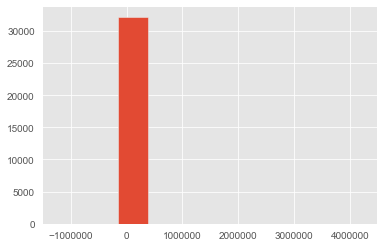

In [36]:
plt.hist(df.loc[:,'PE'], bins=10)

In [37]:
df.describe()

,Shares (Basic),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),Non-Operating Income (Loss),...,ICR,BVPS,DY,EPS,PE,GMR,OMR,ROA,ROE,shifted_chg
count,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,...,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,3.220700e+04,32207.000000,32207.000000,32207.000000,32207.000000,32207.000000
mean,2.611853e+08,2.179748e+09,-1.424917e+09,7.542367e+08,-4.866671e+08,-3.247286e+08,-3.365971e+07,1.060222e+08,2.678696e+08,-4.165426e+07,...,8.257990e+01,-2.520243e+03,-1.408938e+06,2.498583e+03,2.464032e+02,0.456743,-3.939537,0.255218,-0.525519,0.121452
std,6.130852e+09,6.996179e+09,5.201449e+09,2.185339e+09,1.440301e+09,1.189292e+09,1.543209e+08,3.634836e+08,1.007243e+09,4.034849e+08,...,2.374259e+04,1.282325e+06,2.173685e+07,1.272689e+05,2.627325e+04,1.441611,247.590014,47.382009,278.559319,10.120883
min,-8.337042e+11,3.920000e+02,-1.049070e+11,-8.407000e+09,-2.916000e+10,-2.916000e+10,-6.495000e+09,-6.682000e+09,-7.365000e+09,-1.485200e+10,...,-8.702510e+05,-1.603000e+08,-3.790323e+09,-5.515012e+03,-1.243322e+06,-74.642857,-39497.000000,-202.639362,-44487.427466,-1.000000
25%,3.323433e+07,1.299335e+08,-8.980000e+08,4.930050e+07,-3.960000e+08,-2.505910e+08,-5.742000e+06,3.909500e+06,5.482500e+06,-2.955350e+07,...,-1.497446e+01,4.909157e+00,-7.659691e+05,9.749108e-01,9.016438e+00,0.264479,0.035681,0.001716,0.003065,-0.076398
50%,8.505342e+07,5.118000e+08,-2.366970e+08,2.071860e+08,-1.283450e+08,-6.660000e+07,0.000000e+00,2.080000e+07,5.715500e+07,-5.575000e+06,...,-5.224002e+00,1.193342e+01,-2.410390e+04,2.132349e+00,1.658252e+01,0.408596,0.106877,0.011518,0.027622,0.026087
75%,2.383480e+08,1.668500e+09,-3.827500e+07,6.138975e+08,-3.516100e+07,-1.323400e+07,0.000000e+00,7.831950e+07,2.112900e+08,-1.790000e+05,...,-1.148489e+00,2.303150e+01,0.000000e+00,4.035121e+00,2.734763e+01,0.643330,0.189495,0.022605,0.052737,0.127299
max,2.790990e+11,1.387930e+11,1.076300e+10,4.162500e+10,8.986400e+09,5.319000e+08,1.174000e+09,8.302000e+09,3.347100e+10,7.508000e+09,...,4.162698e+06,4.988158e+07,1.101899e+08,1.220000e+07,4.202616e+06,213.500000,32.400000,8498.284508,22354.901416,1479.000000


In [38]:
df.to_csv('finance_data.csv')

# Model Creation

In [42]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [43]:
df.loc[:,'pos_neg']

Ticker  Fiscal Year  Fiscal Period
A       2014         Q1               False
                     Q2                True
                     Q3               False
                     Q4               False
        2015         Q1                True
                                      ...  
ZUMZ    2019         Q1                True
ZYNE    2015         Q3               False
                     Q4               False
        2016         Q1               False
low     2019         Q1                True
Name: pos_neg, Length: 32207, dtype: bool

In [44]:
Y = df.loc[:,'pos_neg']
df = df.drop(columns=['pos_neg'])
X = df.drop(columns=['report_date'])

In [45]:
norms = normalize(X.values, axis=0)
norms

array([[ 3.02385716e-04,  7.66501792e-04, -5.14544024e-04, ...,
         2.15569075e-06,  7.16127541e-07, -3.89109926e-05],
       [ 3.02385716e-04,  7.51293423e-04, -5.19710129e-04, ...,
         1.48254760e-06,  4.93965584e-07,  2.08846139e-05],
       [ 3.03293781e-04,  7.67262211e-04, -5.23843012e-04, ...,
         1.66545083e-06,  5.21376402e-07, -7.95027537e-06],
       ...,
       [ 8.06900846e-06,  3.74696189e-08,  0.00000000e+00, ...,
        -1.46565499e-05, -2.74029761e-06, -3.38956638e-05],
       [ 8.01272295e-06,  5.51303372e-09,  0.00000000e+00, ...,
        -1.28762947e-05, -2.36661459e-06, -1.51468897e-04],
       [ 7.22819910e-04,  1.34905836e-02, -1.25639665e-02, ...,
         2.84622221e-06,  6.46600910e-06,  1.06765750e-04]])

In [46]:
y_norms = normalize(Y.values.reshape(-1, 1))
y_norms

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(norms, y_norms, test_size=0.2)

In [48]:
from sklearn.linear_model import SGDClassifier

In [75]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000)
clf.fit(X_train, y_train)

/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [77]:
predictions = clf.predict(X_test)

In [80]:
np.sum(predictions), predictions.shape


(6442.0, (6442,))

In [70]:
y_test[0:10]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [72]:
from sklearn.model_selection import cross_val_score
# clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=5)

/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Con

In [85]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer

make_pipeline(Binarizer(), PCA())


Pipeline(memory=None,
         steps=[('binarizer', Binarizer(copy=True, threshold=0.0)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [86]:
pipe.fit(X_train, y_train)

/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [87]:
y_train.shape

(25765, 1)

In [89]:
pipe

Pipeline(memory=None,
         steps=[('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [1]:
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


ModuleNotFoundError: No module named 'tensorflow'

In [4]:
!pip3 install tensorflow

Traceback (most recent call last):
  File "/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 583, in _build_master
    ws.require(__requires__)
  File "/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 900, in require
    needed = self.resolve(parse_requirements(requirements))
  File "/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 791, in resolve
    raise VersionConflict(dist, req).with_context(dependent_req)
pkg_resources.VersionConflict: (pip 19.2.2 (/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages), Requirement.parse('pip==18.1'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chrisamoroso/anaconda3/bin/pip3", line 6, in <module>
    from pkg_resources import load_entry_point
  File "/Users/chrisamoroso/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 3241

In [ ]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=256, activation='relu')
model.add(Dense(units=256, activation='relu')
model.add(Dense(units=128, activation='relu')
model.add(Dense(units=64, activation='relu')
model.add(Dense(units=16, activation='relu')
model.add(Dense(units=1, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
          
model.fit(X_train)